# **Minimizing Delta Flight Departure Delays from Hartsfield-Jackson Atlanta International Airport**

## Problem Statement:
Flight delays not only inconvenience passengers but also result in significant operational costs for airlines. For Hartsfield-Jackson Atlanta International Airport, known for its heavy traffic, minimizing departure delays is crucial. The focus of this project is to predict departure delays for Delta Airlines flights departing from Hartsfield-Jackson Atlanta International Airport during the years 2022 and 2023. Utilizing historical departure data, we aim to develop a model that can forecast delays, thereby assisting in improving operational efficiency and enhancing passenger satisfaction


## Objective:

The objective of this project is to apply three predictive analytics methods—SARIMA, LSTM, and Prophet Model—to forecast flight delays for Delta Airlines flights departing from Atlanta Airport. By leveraging historical data on flight timings, airport traffic, and other relevant factors, the project aims to:


*   Use SARIMA's strength in analyzing delays influenced by seasonal travel trends and operational factors.
*   Employ LSTM networks to capture complex nonlinear dependencies and long-term historical contexts in the delay data.
*   Apply the Prophet Model to forecast flight delays by accommodating yearly, weekly, and daily seasonality, along with holiday effects.








### Dataset Overview:


*   Approximately 429,000 records of flight departure data from the Bureau of Transportation Statistics ​
*   Delta Airlines flights from Hartsfield-Jackson Atlanta International Airport in 2022 and 2023​
*   Includes the date, flight details, scheduled and actual departure times, departure delay (in minutes), delay reasons​




In [ ]:
!pip install pmdarima

In [ ]:
# imports again just so we don't have to scroll unnecessarily
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

Data Loading

In [ ]:
df = pd.read_csv('/content/Detailed_Statistics_Departures.csv')
desc_stats = df.describe()
desc_stats

,Flight Number,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
count,429887.000000,429887.000000,429887.000000,429887.000000,429887.000000,429887.000000,429887.000000,429887.000000,429887.000000,429887.000000
mean,1723.529155,127.540119,120.140483,9.420034,15.139458,5.676752,0.569738,1.702198,0.013429,1.633099
std,840.295010,70.077595,70.221002,36.928663,6.655771,28.508518,11.279756,11.642487,0.892037,10.884841
min,12.000000,41.000000,0.000000,-34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,995.000000,83.000000,76.000000,-3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1682.000000,109.000000,102.000000,-1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2455.000000,140.000000,134.000000,7.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8819.000000,625.000000,719.000000,1256.000000,171.000000,1256.000000,995.000000,1138.000000,156.000000,453.000000


In [ ]:
df.head(), df.columns

(  Carrier Code Date (MM/DD/YYYY)  Flight Number Tail Number  \
 0           DL          1/1/2022          306.0      N390DN   
 1           DL          1/1/2022          333.0      N321DH   
 2           DL          1/1/2022          334.0      N823NW   
 3           DL          1/1/2022          335.0      N117DX   
 4           DL          1/1/2022          345.0      N367DN   
 
   Destination Airport Scheduled departure time Actual departure time  \
 0                 DCA                    10:00                 10:00   
 1                 BOS                    17:45                 17:43   
 2                 SEA                     8:10                  8:19   
 3                 LAX                    15:57                 16:03   
 4                 LAX                     8:56                  8:53   
 
    Scheduled elapsed time (Minutes)  Actual elapsed time (Minutes)  \
 0                              99.0                           98.0   
 1                             1

In [ ]:
missing_values = df.isnull().sum()
missing_values

Carrier Code                                 1
Date (MM/DD/YYYY)                            2
Flight Number                                2
Tail Number                                 42
Destination Airport                          2
Scheduled departure time                     2
Actual departure time                        2
Scheduled elapsed time (Minutes)             2
Actual elapsed time (Minutes)                2
Departure delay (Minutes)                    2
Wheels-off time                              2
Taxi-Out time (Minutes)                      2
Delay Carrier (Minutes)                      2
Delay Weather (Minutes)                      2
Delay National Aviation System (Minutes)     2
Delay Security (Minutes)                     2
Delay Late Aircraft Arrival (Minutes)        2
dtype: int64

Missing Data Imputation and Exploratory Analysis

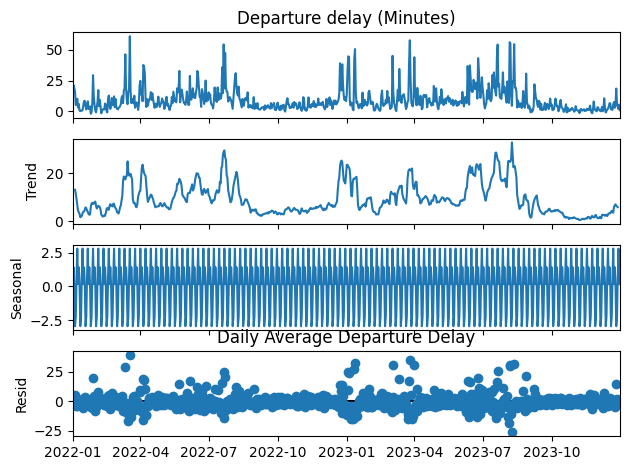

In [ ]:
# convert 'Date (MM/DD/YYYY)' to datetime and set as index and sort by index
df['Date'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], errors='coerce', format='%m/%d/%Y')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# calculate the mean departure delay for each day
daily_delays = df['Departure delay (Minutes)'].resample('D').mean()

# Linear Interpolation
daily_delays.interpolate(method='linear', inplace=True)

result = seasonal_decompose(daily_delays, model='additive')

result.plot()
plt.title('Daily Average Departure Delay')
plt.show()

In [ ]:
daily_delays

Date
2022-01-01    14.343358
2022-01-02    21.381215
2022-01-03    18.876611
2022-01-04    15.828467
2022-01-05     5.059048
                ...    
2023-12-27     6.050877
2023-12-28     4.040140
2023-12-29     1.588542
2023-12-30     5.415330
2023-12-31     0.803653
Name: Departure delay (Minutes), Length: 730, dtype: float64

In [ ]:
years = [2022,2023]
for year in years:
    yearly_data = daily_delays[daily_delays.index.year == year]
    print(f"Year: {year}, Data points: {len(yearly_data)}")


Year: 2022, Data points: 365
Year: 2023, Data points: 365


Time Series Analysis of Delays for 2022

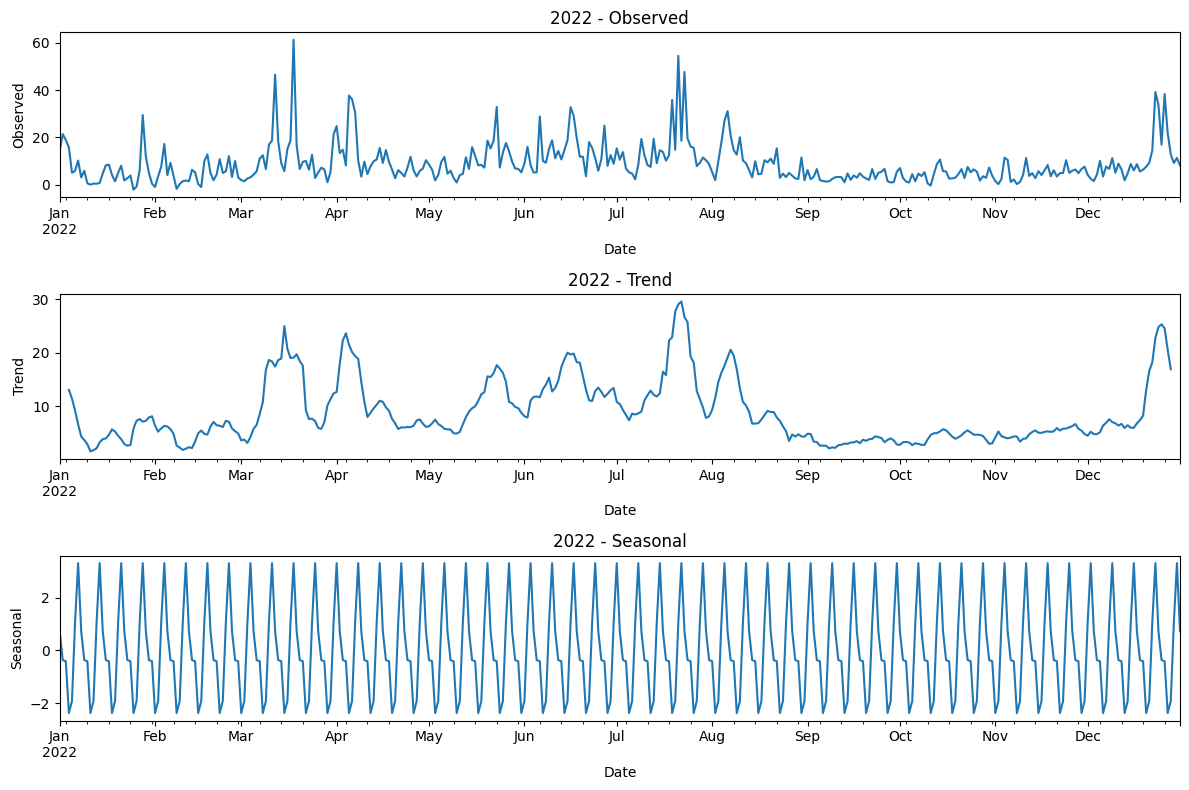

In [ ]:
year_2022_data = daily_delays[daily_delays.index.year == 2022]

result_2022 = seasonal_decompose(year_2022_data, model='additive')

plt.figure(figsize=(12, 8))

plt.subplot(311)
result_2022.observed.plot(title='2022 - Observed')
plt.ylabel('Observed')

plt.subplot(312)
result_2022.trend.plot(title='2022 - Trend')
plt.ylabel('Trend')

plt.subplot(313)
result_2022.seasonal.plot(title='2022 - Seasonal')
plt.ylabel('Seasonal')

plt.tight_layout()
plt.show()


Time Series Analysis of Delays for 2023

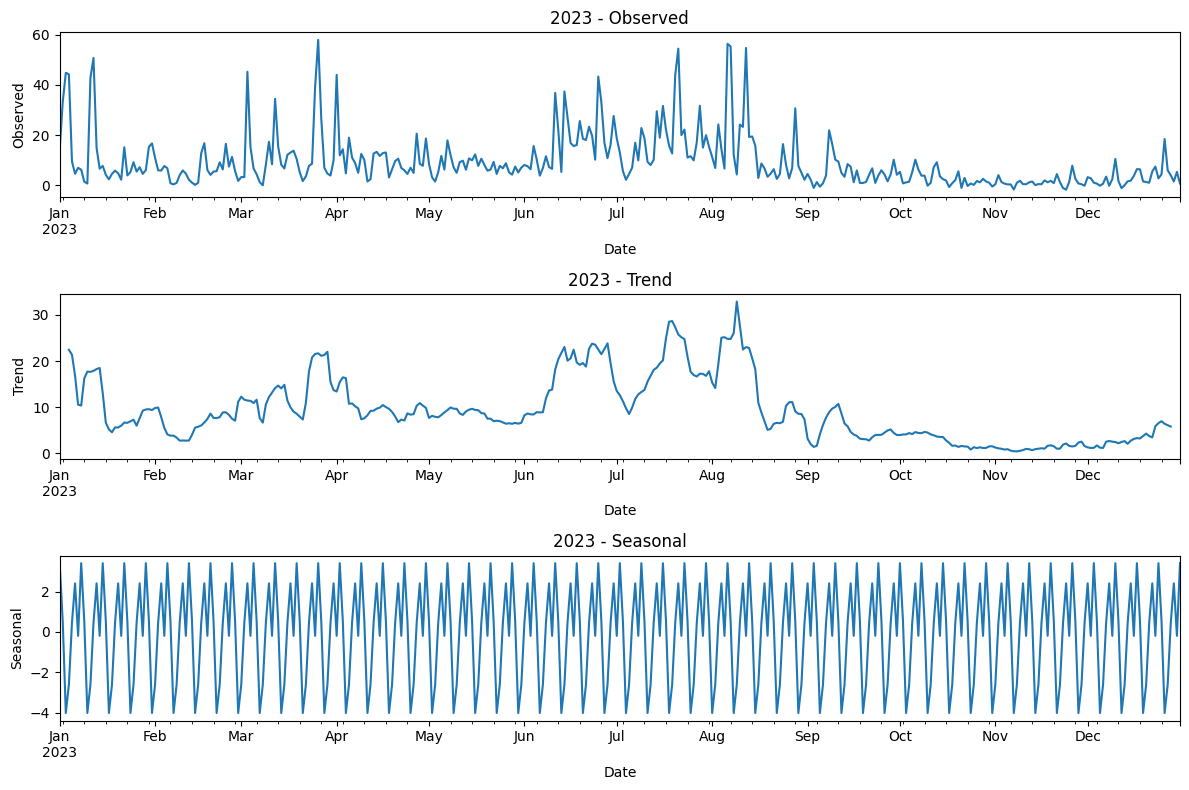

In [ ]:
year_2023_data = daily_delays[daily_delays.index.year == 2023]

result_2023 = seasonal_decompose(year_2023_data, model='additive')

plt.figure(figsize=(12, 8))

plt.subplot(311)
result_2023.observed.plot(title='2023 - Observed')
plt.ylabel('Observed')

plt.subplot(312)
result_2023.trend.plot(title='2023 - Trend')
plt.ylabel('Trend')

plt.subplot(313)
result_2023.seasonal.plot(title='2023 - Seasonal')
plt.ylabel('Seasonal')

plt.tight_layout()
plt.show()


Stationarity ADF Test

In [ ]:
#check stationarity

adf_test = adfuller(daily_delays.dropna())

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")


ADF Statistic: -3.800738
p-value: 0.002900
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
The time series is likely stationary.


ACF and PACF Plots

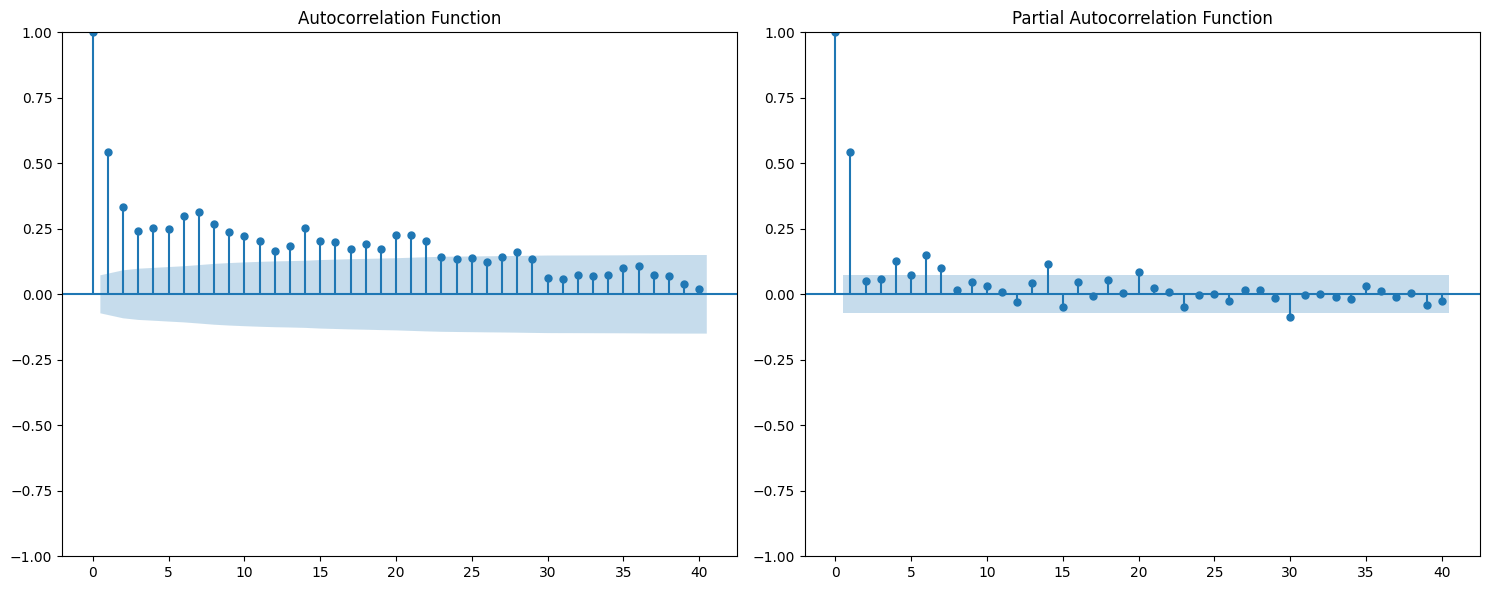

In [ ]:
#check seasonality
# plot ACF and PACF
plt.figure(figsize=(15, 6))
plt.subplot(121)
plot_acf(daily_delays, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(daily_delays, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


Approach 1: Time Series Modeling - SARIMA

In [ ]:
# split into train and test datasets, where 30 is to reserve the last 30 days as the test set
test_size = 30
train, test = daily_delays[:-test_size], daily_delays[-test_size:]

In [ ]:
# using auto_sarima to find optimal parameters on the training set
sarima_model = auto_arima(train, seasonal=True, m=12, trace=True,
                          error_action='ignore', suppress_warnings=True)

print(sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.01 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5178.029, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4940.561, Time=0.68 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4997.596, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5642.336, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4938.564, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4940.561, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4942.561, Time=0.92 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4939.067, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4938.571, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5000.317, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=4910.876, Time=0.78 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=4909.797, Time=2.67 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=4911.511, Time=9.53 sec
 ARIMA(2,0,1)(1,0,1)[12]

In [ ]:
# fit SARIMA model with the optimal parameters found by auto_arima
#Best model:  ARIMA(4,0,1)(0,0,1)[12] intercept
model = SARIMAX(train,
                order=(4, 0, 1),
                seasonal_order=(0, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:          Departure delay (Minutes)   No. Observations:                  700
Model:             SARIMAX(4, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -2403.027
Date:                            Fri, 19 Apr 2024   AIC                           4820.055
Time:                                    13:55:34   BIC                           4851.771
Sample:                                01-01-2022   HQIC                          4832.327
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3353      0.037     36.069      0.000       1.263       1.408
ar.L2         -0.3951      0.044   

In [ ]:
# Model Predictions
preds = results.get_forecast(steps=test_size)
prediction_intervals = preds.conf_int()

Predicted vs Actual

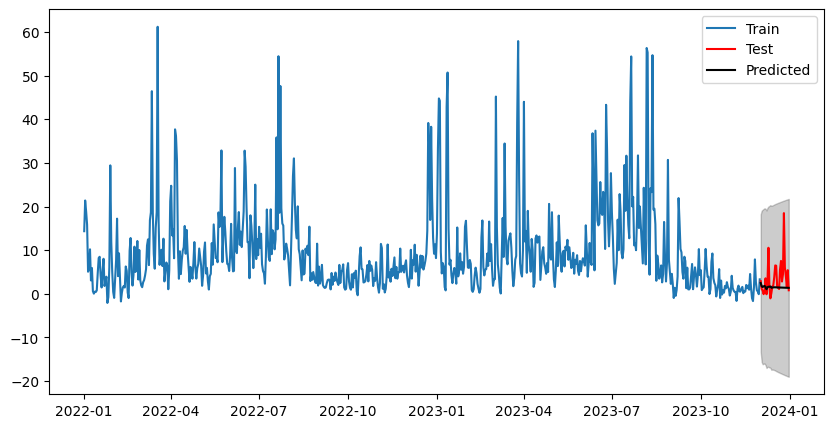

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(test.index, preds.predicted_mean, label='Predicted', color='k')

plt.fill_between(test.index,
                 prediction_intervals.iloc[:, 0],
                 prediction_intervals.iloc[:, 1], color='k', alpha=0.2)

plt.legend()
plt.show()


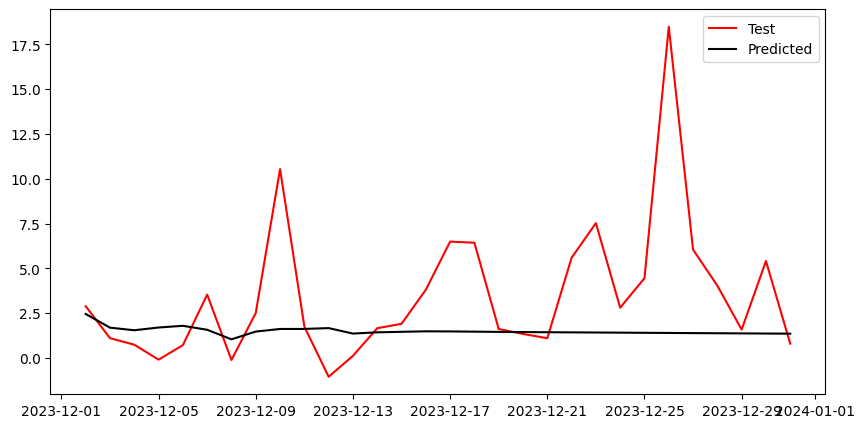

In [ ]:
# plot test vs predicted values
plt.figure(figsize=(10, 5))

plt.plot(test.index, test, label='Test', color='r')

plt.plot(test.index, preds.predicted_mean, label='Predicted', color='k')
plt.legend()
plt.show()

## Approach 2:Recurrent Neural Network - Long Short Term Memory LSTM


In [ ]:
#importing the required libraries for the model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from sklearn.preprocessing import MinMaxScaler


## Data Preprocessing

In [ ]:
df = df.dropna()
df.isna().sum()
df.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
Date,,,,,,,,,,,,,,,,,
2022-01-01,DL,1/1/2022,306.0,N390DN,DCA,10:00,10:00,99.0,98.0,0.0,10:24,24.0,0.0,0.0,0.0,0.0,0.0
2022-01-01,DL,1/1/2022,2368.0,N821DX,MSY,15:11,15:50,94.0,88.0,39.0,16:02,12.0,15.0,0.0,0.0,0.0,18.0
2022-01-01,DL,1/1/2022,2367.0,N828DN,CHS,9:59,0:00,73.0,0.0,0.0,0:00,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01,DL,1/1/2022,2362.0,N676DL,RSW,10:18,11:20,101.0,95.0,62.0,11:33,13.0,56.0,0.0,0.0,0.0,0.0
2022-01-01,DL,1/1/2022,2361.0,N320NB,OMA,15:55,15:52,145.0,140.0,-3.0,16:03,11.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Temporal Features
df['Day'] = pd.to_datetime(df['Date (MM/DD/YYYY)']).dt.day
df['Month'] = pd.to_datetime(df['Date (MM/DD/YYYY)']).dt.month
df['Weekday'] = pd.to_datetime(df['Date (MM/DD/YYYY)']).dt.weekday
df['Hour'] = pd.to_datetime(df['Scheduled departure time']).dt.hour

<ipython-input-33-f982fed356ec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Scheduled departure time']).dt.hour


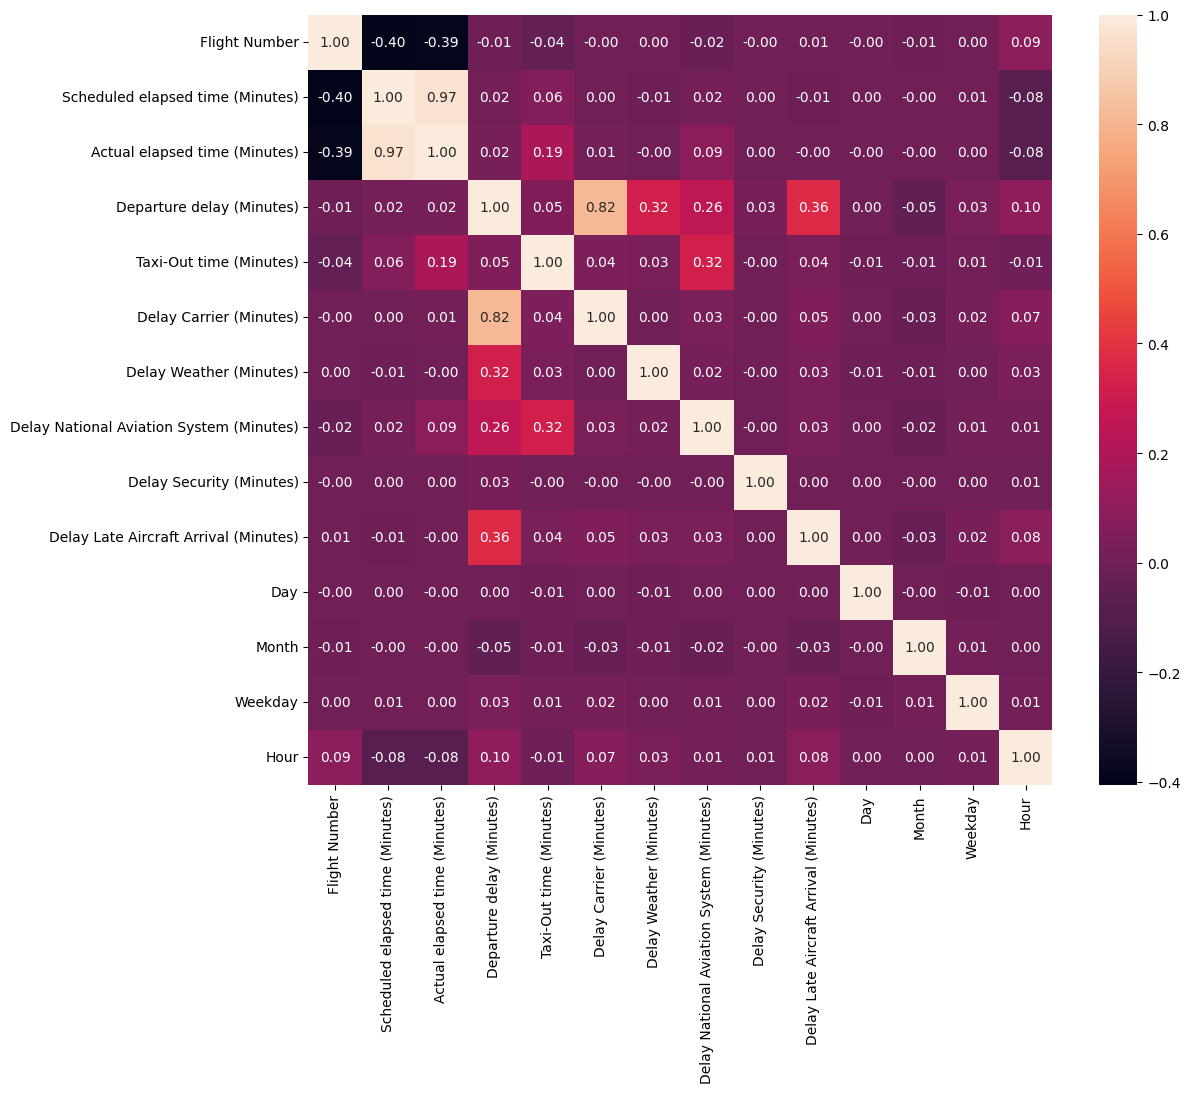

In [ ]:
#Correlation Matrix
import seaborn as sns
numeric_features = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()


In [ ]:
numeric_columns = ['Scheduled elapsed time (Minutes)', 'Taxi-Out time (Minutes)']
categorical_columns = [ 'Destination Airport']

In [ ]:
# Scaling numeric columns
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Label encoding for 'Destination Airport'
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Destination Airport'] = label_encoder.fit_transform(df['Destination Airport'])

In [ ]:
feature_columns = numeric_columns + ['Day', 'Month', 'Weekday', 'Hour', 'Destination Airport']
features = df[feature_columns]
features.head()

,Scheduled elapsed time (Minutes),Taxi-Out time (Minutes),Day,Month,Weekday,Hour,Destination Airport
Date,,,,,,,
2022-01-01,0.099315,0.140351,1,1,5,10,30
2022-01-01,0.090753,0.070175,1,1,5,15,81
2022-01-01,0.054795,0.000000,1,1,5,9,20
2022-01-01,0.102740,0.076023,1,1,5,10,105
2022-01-01,0.178082,0.064327,1,1,5,15,87


In [ ]:
target = df['Departure delay (Minutes)']

In [ ]:
# Convert DataFrame to sequences for LSTM
def create_sequences(X, y, time_steps=100):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(features, target)

## LSTM Model Structure

In [ ]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Building the LSTM model
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 128)          69632     
                                                                 
 dropout_2 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 201345 (786.50 KB)
Trainable params: 201345 (786.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Training

In [ ]:
# Fit model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
4835/4835 [==============================] - 55s 11ms/step - loss: 1376.1440 - val_loss: 2493.2205
Epoch 2/10
4835/4835 [==============================] - 55s 11ms/step - loss: 1374.4435 - val_loss: 2426.7905
Epoch 3/10
4835/4835 [==============================] - 54s 11ms/step - loss: 1371.6283 - val_loss: 2426.1736
Epoch 4/10
4835/4835 [==============================] - 54s 11ms/step - loss: 1371.5753 - val_loss: 2484.1174
Epoch 5/10
4835/4835 [==============================] - 54s 11ms/step - loss: 1369.3942 - val_loss: 2431.5364
Epoch 6/10
4835/4835 [==============================] - 55s 11ms/step - loss: 1364.5631 - val_loss: 2443.3135
Epoch 7/10
4835/4835 [==============================] - 54s 11ms/step - loss: 1363.8643 - val_loss: 2423.2561
Epoch 8/10
4835/4835 [==============================] - 54s 11ms/step - loss: 1360.8000 - val_loss: 2463.0159
Epoch 9/10
4835/4835 [==============================] - 55s 11ms/step - loss: 1360.3120 - val_loss: 2439.6289
Epoch 10/1

In [ ]:
# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print("Test Loss:", evaluation)

2686/2686 [==============================] - 16s 6ms/step - loss: 709.8242
Test Loss: 709.8241577148438


In [ ]:
predicted_delay = model.predict(X_test)
#predicted_delay = scaler.inverse_transform(predicted_delay)



2686/2686 [==============================] - 14s 5ms/step


In [ ]:
y_test[:-20]

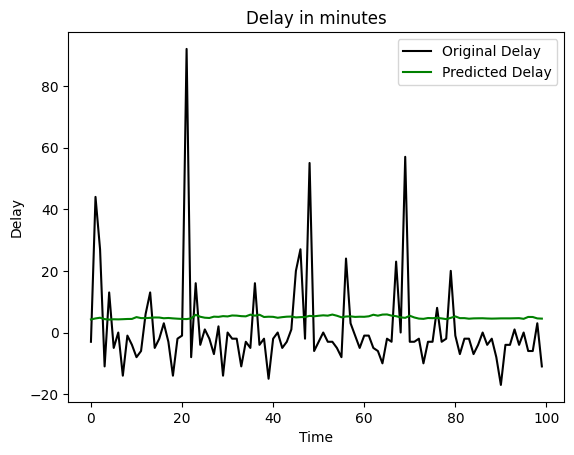

In [ ]:
plt.plot(y_test[-100:], color = 'black', label = 'Original Delay')
plt.plot(predicted_delay[-100:], color = 'green', label = 'Predicted Delay')
plt.title('Delay in minutes')
plt.xlabel('Time')
plt.ylabel('Delay')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, predicted_delay, squared = False))
print(mean_absolute_error(y_test, predicted_delay))

26.642522311559198
11.676461976274908


In [ ]:
y_train_pred = model.predict(X_train)

10744/10744 [==============================] - 47s 4ms/step


In [ ]:
mse_train = mean_squared_error(y_train, y_train_pred, squared = False)
mae_train = mean_absolute_error(y_train, y_train_pred)

In [ ]:
print(mse_train)
print(mae_train)

38.27455875153308
16.45534600431639


## Approach 3: Facebook Prophet Model

In [1]:
!pip install prophet
!pip install scikit-learn

In [2]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
daily_delays = pd.read_csv('/content/Detailed_Statistics_Departures.csv')

daily_delays['Date (MM/DD/YYYY)'] = pd.to_datetime(daily_delays['Date (MM/DD/YYYY)'])

# rename columns for Prophet compatibility
daily_delays.rename(columns={'Date (MM/DD/YYYY)': 'ds', 'Departure delay (Minutes)': 'y'}, inplace=True)

daily_avg_delays = daily_delays.groupby('ds')['y'].mean().reset_index()



<ipython-input-3-9bbc978c1896>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_delays['Date (MM/DD/YYYY)'] = pd.to_datetime(daily_delays['Date (MM/DD/YYYY)'])


# Data Loading and Preprocessing

In [4]:
daily_delays = pd.read_csv('/content/Detailed_Statistics_Departures.csv')

daily_delays['Date (MM/DD/YYYY)'] = pd.to_datetime(daily_delays['Date (MM/DD/YYYY)'])

# rename columns for Prophet compatibility
daily_delays.rename(columns={'Date (MM/DD/YYYY)': 'ds', 'Departure delay (Minutes)': 'y'}, inplace=True)

daily_avg_delays = daily_delays.groupby('ds')['y'].mean().reset_index()


<ipython-input-4-3b83adfa7fcf>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_delays['Date (MM/DD/YYYY)'] = pd.to_datetime(daily_delays['Date (MM/DD/YYYY)'])


In [5]:
train = daily_avg_delays[daily_avg_delays['ds'] < '2023-12-01']
test = daily_avg_delays[daily_avg_delays['ds'] >= '2023-12-01']

# fit the model
model = Prophet()
model.fit(train)

future = test[['ds']]

forecast = model.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6mifnhc/c8ur9kqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6mifnhc/61o635f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40643', 'data', 'file=/tmp/tmp_6mifnhc/c8ur9kqj.json', 'init=/tmp/tmp_6mifnhc/61o635f5.json', 'output', 'file=/tmp/tmp_6mifnhc/prophet_modeljpzv1oyo/prophet_model-20240419172611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [6]:
# evaluate the model for training and testing data
future_train = model.make_future_dataframe(periods=0, freq='D', include_history=True)
future_train = future_train[future_train['ds'] <= train['ds'].max()]  # Ensuring it only contains training data dates

forecast_train = model.predict(future_train)

train_mae = mean_absolute_error(train['y'], forecast_train['yhat'])
train_rmse = np.sqrt(mean_squared_error(train['y'], forecast_train['yhat']))

print(f"Training Data MAE: {train_mae}")
print(f"Training Data RMSE: {train_rmse}")

test_mae = mean_absolute_error(test['y'], forecast['yhat'])
test_rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))

print(f"Testing Data MAE: {test_mae}")
print(f"Testing Data RMSE: {test_rmse}")


Training Data MAE: 6.186336140685261
Training Data RMSE: 9.289755675314657
Testing Data MAE: 3.267028849774767
Testing Data RMSE: 4.547993017598044


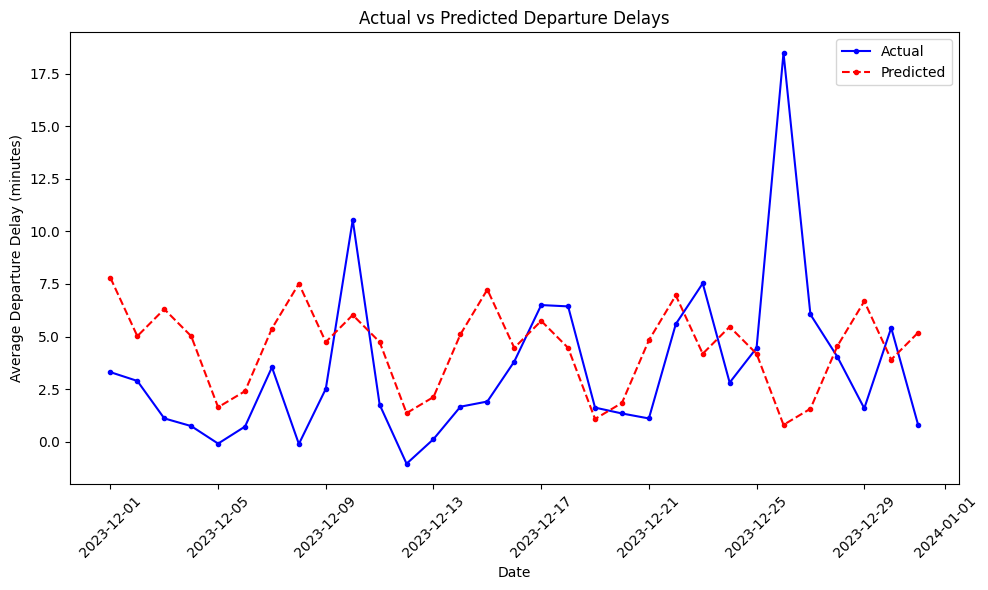

In [7]:
# plot the actual vs. predicted graph

comparison_df = test.merge(forecast[['ds', 'yhat']], on='ds', how='left')

plt.figure(figsize=(10, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Actual', marker='.', linestyle='-', color='blue')
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Predicted', marker='.', linestyle='--', color='red')

plt.title('Actual vs Predicted Departure Delays')
plt.xlabel('Date')
plt.ylabel('Average Departure Delay (minutes)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## Tuning the Facebook Prophet model

In [8]:
# specifying holidays with an upper and lower window (days to consider around the holidays)
holidays = pd.DataFrame({
  'holiday': 'US Public Holidays',
  'ds': pd.to_datetime([
      '2022-01-01',  # New Year's Day
      '2022-07-04',  # Independence Day
      '2022-11-24',  # Thanksgiving Day
      '2022-12-25',  # Christmas Day
      '2023-01-01',  # New Year's Day
      '2023-07-04',  # Independence Day
      '2023-11-24',  # Thanksgiving Day
      '2023-12-25',  # Christmas Day
  ]),
  'lower_window': -2,
  'upper_window': 2,
})



In [9]:
# fit the Prophet Model
train = daily_avg_delays[daily_avg_delays['ds'] < '2023-12-01']
test = daily_avg_delays[daily_avg_delays['ds'] >= '2023-12-01']

model = Prophet(
    growth='linear',
    daily_seasonality='auto',
    weekly_seasonality='auto',
    yearly_seasonality='auto',
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.055,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    interval_width=0.80,
    uncertainty_samples=1000
)

model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6mifnhc/uf1ih8gg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_6mifnhc/61mjeb6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91933', 'data', 'file=/tmp/tmp_6mifnhc/uf1ih8gg.json', 'init=/tmp/tmp_6mifnhc/61mjeb6b.json', 'output', 'file=/tmp/tmp_6mifnhc/prophet_modelfhg_nc2m/prophet_model-20240419172625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
# evaluate the model
train_future = model.make_future_dataframe(periods=0, freq='D', include_history=True)
train_forecast = model.predict(train_future)
train_mae = mean_absolute_error(train['y'], train_forecast['yhat'])
train_rmse = np.sqrt(mean_squared_error(train['y'], train_forecast['yhat']))

test_future = test[['ds']]
test_forecast = model.predict(test_future)
test_mae = mean_absolute_error(test['y'], test_forecast['yhat'])
test_rmse = np.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))

print(f"Training MAE: {train_mae}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing RMSE: {test_rmse}")

Training MAE: 6.058140268847338
Training RMSE: 9.125993239518298
Testing MAE: 2.4930166149844593
Testing RMSE: 3.425036762425132


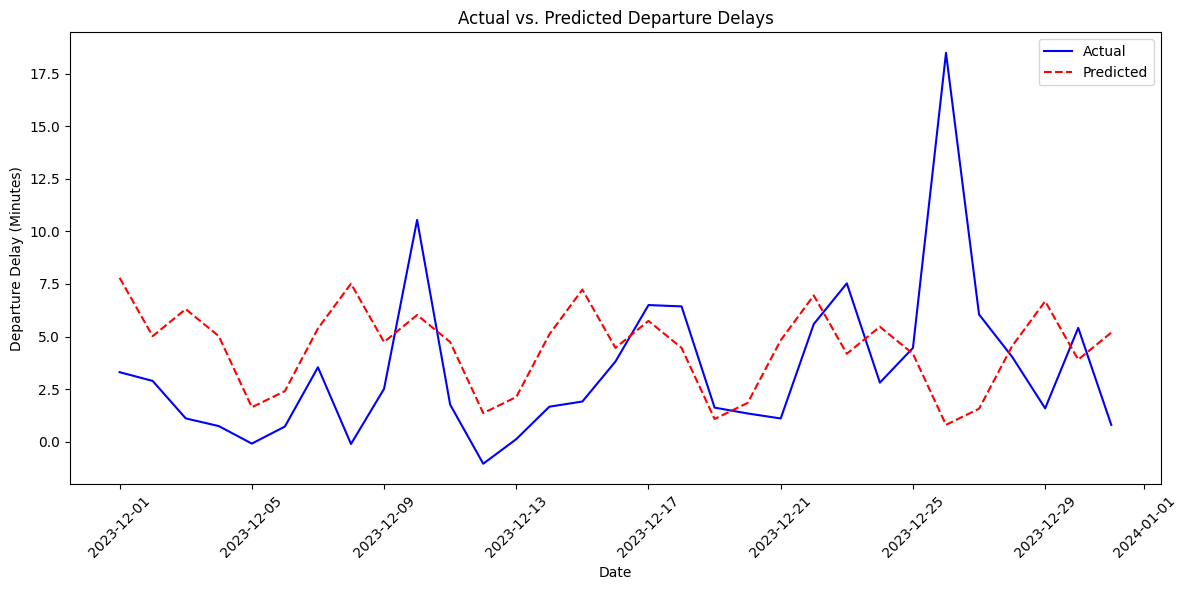

In [11]:
comparison_df = test.merge(forecast[['ds', 'yhat']], on='ds')

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], 'b-', label='Actual')
plt.plot(comparison_df['ds'], comparison_df['yhat'], 'r--', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Departure Delay (Minutes)')
plt.title('Actual vs. Predicted Departure Delays')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()